In [150]:
import torch as pt
import torchvision as tv
import matplotlib.pyplot as plt
from torchinfo import summary

import data_setup
import engine

In [151]:
device = 'cuda' if pt.cuda.is_available() else 'cpu'
device

'cpu'

In [152]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [153]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [154]:
# This basically takes the default transforms for EfficientNet_B0_Weights
weights = tv.models.EfficientNet_B0_Weights.DEFAULT

auto_transforms = weights.transforms()
print(weights, "\n\n", auto_transforms)

EfficientNet_B1_Weights.IMAGENET1K_V2 

 ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [155]:
train_dataloader, test_dataloader, class_names, train_dataset, test_dataset = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32, num_workers=0)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x16ba7e3d390>,
 ['pizza', 'steak', 'sushi'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


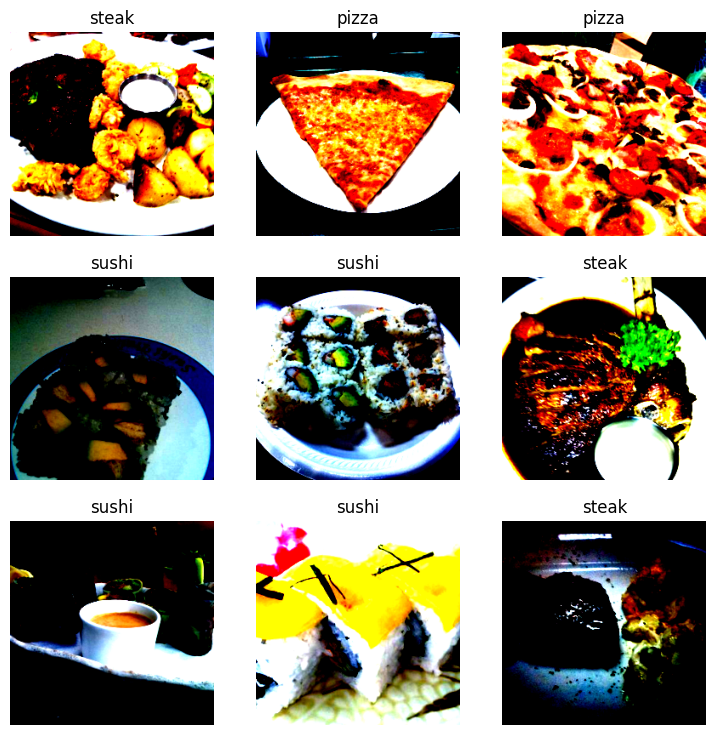

In [156]:
from ml_funcs import view
view.rand_images(
    test_dataset,
    42,
    3,
    3,
    (9,9)
)

In [157]:
import torchvision as tv
# Issue arose when trying to download model, following commands seems to have fixed issue, imported from cgpt
# import os
# os.environ['REQUESTS_CA_BUNDLE'] = '/path/to/certificate_bundle.crt'

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context


model = tv.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to C:\Users\22gusgam/.cache\torch\hub\checkpoints\efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 38.3MB/s]


In [158]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [159]:
for param in model.features.parameters():
    param.requires_grad = False

In [160]:
pt.manual_seed(42)
pt.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = pt.nn.Sequential(
    pt.nn.Dropout(p=0.2, inplace=True),
    pt.nn.Linear(in_features=1280,
                 out_features=output_shape,
                 bias=True).to(device)
)

In [161]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [162]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = pt.optim.Adam(params=model.parameters(), lr=0.001)

In [163]:
pt.manual_seed(42)
pt.cuda.manual_seed(42)

from ml_funcs import Timer
timer = Timer()
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
timer.show_as_print()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0864 | train_acc: 0.4492 | test_loss: 1.0004 | test_acc: 0.6411
Epoch: 2 | train_loss: 0.9280 | train_acc: 0.8555 | test_loss: 0.9267 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.8420 | train_acc: 0.8789 | test_loss: 0.8597 | test_acc: 0.7955
Epoch: 4 | train_loss: 0.8919 | train_acc: 0.7773 | test_loss: 0.8115 | test_acc: 0.7945
Epoch: 5 | train_loss: 0.7843 | train_acc: 0.7695 | test_loss: 0.7793 | test_acc: 0.8049

Timer: by GGisMee
Total time:
 309.16



In [15]:
from ml_funcs import save_load
#save_load.save_state_dict(model, 'transfered_model')
model = save_load.load_state_dict(model, 'transfered_model')

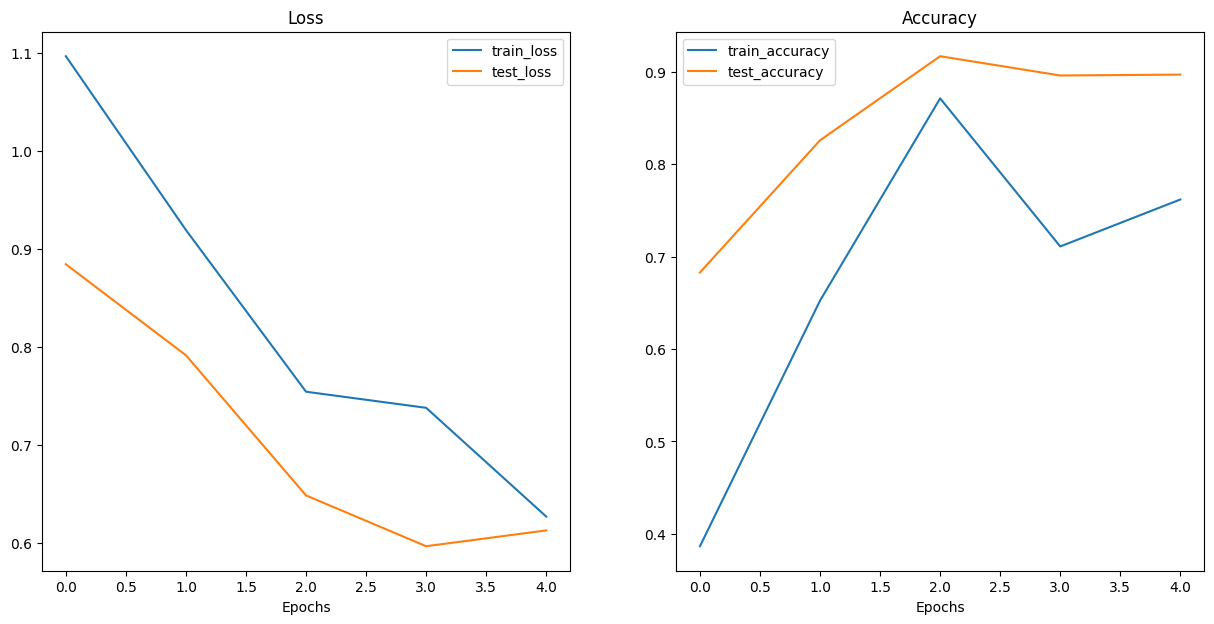

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [16]:
from sys import path
from pathlib import Path
import PIL
import matplotlib.pyplot as plt

def pred_and_plot_image(model:pt.nn.Module, image_path:str, class_names:list[str],device: pt.device, image_size: tuple[int,int] = (224,224), transforms:tv.transforms = None):
    predict_Image = PIL.Image.open(image_path)
    if transforms is not None:
        transformed_image = transforms(predict_Image)
    else:
        transforms = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.224])
        ])
        transformed_image = transforms(predict_Image)
    model.to(device)
    model.eval()
    with pt.inference_mode():
        X_logits = model(transformed_image.unsqueeze(dim=0).to(device)).squeeze(0)
        X_pred_probs = pt.softmax(X_logits, dim=0)
        X_pred = pt.argmax(X_pred_probs,0)
    plt.imshow(predict_Image)
    plt.axis(False)
    plt.title(f'Pred: {class_names[X_pred]} | Prob: {X_pred_probs.max():.3f}')



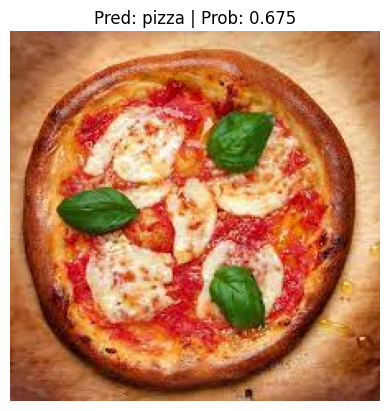

In [40]:
level=1
photo_name = 'pizza1.jpg'

path_chosen = path[0]
base_path = Path(path[0])
predict_dir_path = base_path / 'predict_file'
predict_image_path = predict_dir_path / photo_name

pred_and_plot_image(
    model=model,
    image_path=predict_image_path,
    class_names=class_names,
    device=device,
    image_size=None,
    transforms=auto_transforms
)

C:\Users\22gusgam\AppData\Local\Temp\ipykernel_19844\2714918881.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  confusion_matrix(pt.tensor(preds), pt.tensor(class_samples), class_names)


Our confusion matrix
: tensor([[20,  5,  0],
        [ 2, 16,  1],
        [ 1,  4, 26]])


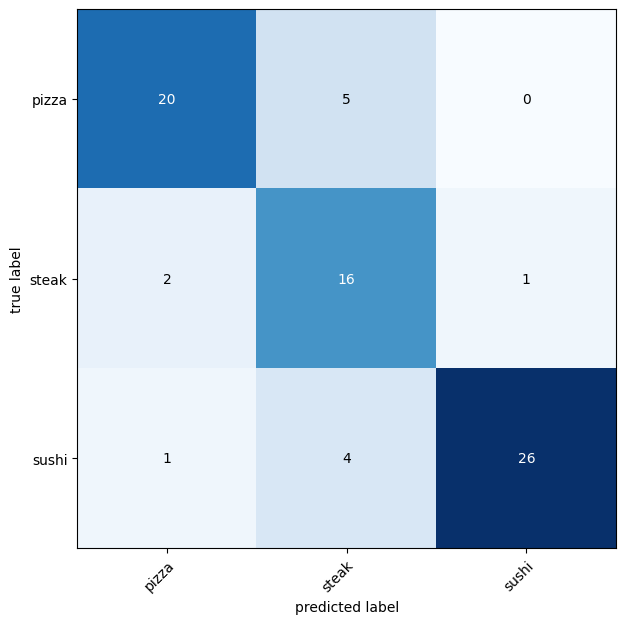

In [164]:
from ml_funcs import Model_operations, get_sample, confusion_matrix
class_samples,image_samples = get_sample(test_dataset, len(test_dataset))
preds = Model_operations.make_predictions(model, image_samples, device=device).argmax(dim=1)
confusion_matrix(pt.tensor(preds), pt.tensor(class_samples), class_names)

In [ ]:
#### Make a plot to show the results that got wrong from preds

In [165]:
from math import sqrt, floor
def plot_wrong(y_preds:pt.Tensor, targets:pt.Tensor, images:list[pt.Tensor], classes:list[str]=None):

    wrong_idx = pt.where(pt.eq(pt.tensor(y_preds),pt.tensor(targets))==False)[0].tolist()
    nrows_ncols = (floor(sqrt(len(wrong_idx))))
    # wrong_preds = y_preds[wrong_idx]
    # wrong_targets = targets[wrong_idx]
    # wrong_images = [images[i] for i in wrong_idx]

    for index, i in list(enumerate(wrong_idx))[:nrows_ncols**2]:
        plt.subplot(nrows_ncols,nrows_ncols, index+1)
        plt.imshow(images[i].permute(1,2,0))
        plt.axis(False)
        if classes:
            plt.title(f'pred: {classes[y_preds[i]]} | target: {classes[targets[i]]}')
        else:
            plt.title(f'pred: {y_preds[i]} | target: {targets[i]}')
    

    


C:\Users\22gusgam\AppData\Local\Temp\ipykernel_19844\439692863.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wrong_idx = pt.where(pt.eq(pt.tensor(y_preds),pt.tensor(targets))==False)[0].tolist()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


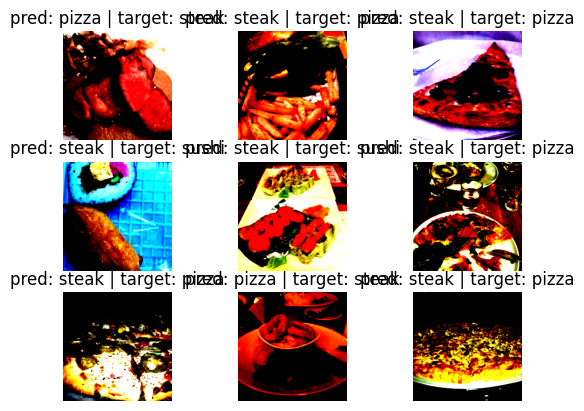

In [166]:
plot_wrong(preds, pt.tensor(class_samples),image_samples,class_names)